In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sportypy.surfaces import MiLBField


# TODO: I'm going to have to adjust my control points to implement more curvature. May try arbitrarily adding in 10. 

In [18]:
final = pd.read_csv('./Clean/flyball_data.csv', dtype={'game_state': str})

In [19]:
# First order of business is to try to eliminate uncatchable fly balls
(final[final['almost_caught'] == 1][['field_x', 'field_end_y', 'actual_distance', 'route_efficiency', 'exit_velocity', 'launch_angle', 'actual_time']]
.describe())


,field_x,field_end_y,actual_distance,route_efficiency,exit_velocity,launch_angle,actual_time
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,4.619573,237.696219,86.668974,0.804131,81.356321,18.227559,3.689154
std,98.942912,50.195242,29.000746,0.125447,11.876906,7.603241,0.881286
min,-170.327100,125.870700,19.137726,0.088609,44.886724,10.015799,2.310000
25%,-111.143400,203.551575,64.012253,0.741705,72.826092,12.685870,3.150000
50%,-3.772500,230.882700,85.965693,0.826742,81.677122,15.973597,3.450000
75%,118.904400,265.696575,106.488946,0.885658,89.930042,21.476931,4.037500
max,160.273800,399.492600,203.033770,0.994442,141.669584,54.164479,8.900000


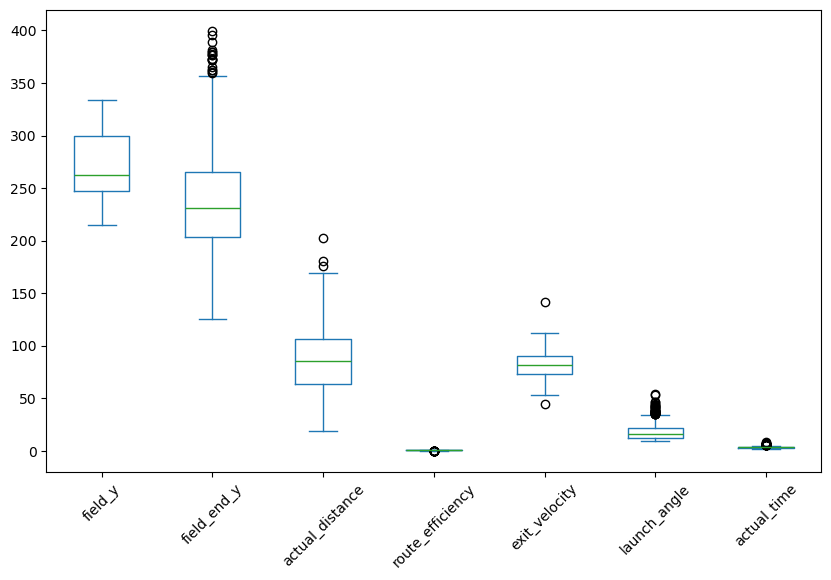

In [20]:
almost_caught = final[final['almost_caught'] == 1][['field_y', 'field_end_y', 'actual_distance', 'route_efficiency', 'exit_velocity', 'launch_angle', 'actual_time']]

plt.rcParams["figure.figsize"] = [10, 6]
almost_caught.plot(kind='box')
plt.xticks(rotation=45)
plt.show()

In [21]:
# I basically compared what caught flyballs look like do determine if a almost caught flyball had
# similar characteristics to that of an actual flyball caught.
# Did stuff like this: final.query('almost_caught == 0 & actual_time < 3')['actual_distance'].mean()
# removes 28 observations
print(len(almost_caught.query('actual_time < 3 & launch_angle < 14 & route_efficiency < 0.8 & actual_distance > 45')))
remove_indices = almost_caught.query('actual_time < 3 & launch_angle < 14 & route_efficiency < 0.8 & actual_distance > 45').index

28


In [22]:
final = final.drop(index=remove_indices)

In [23]:
len(final)

4621

In [25]:
# Remove some outliers in the exit veloicty data
q1 = final['exit_velocity'].quantile(0.25)
q3 = final['exit_velocity'].quantile(0.75)

iqr = q3 - q1


final = final.loc[(final['exit_velocity'] >= q1 - 1.5 * iqr) &
                 (final['exit_velocity'] <= q3 + 1.5 * iqr) &
                 (final['actual_time'] < 8)]

In [26]:
len(final)

4494

In [27]:
cols_to_test = ['p1_y', 'p2_y','game_state', 'handedness', 'exit_velocity', 'launch_angle', 
                'initial_angle', 'max_player_speed', 'actual_time', 'angle_error',
               'mean_speed']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

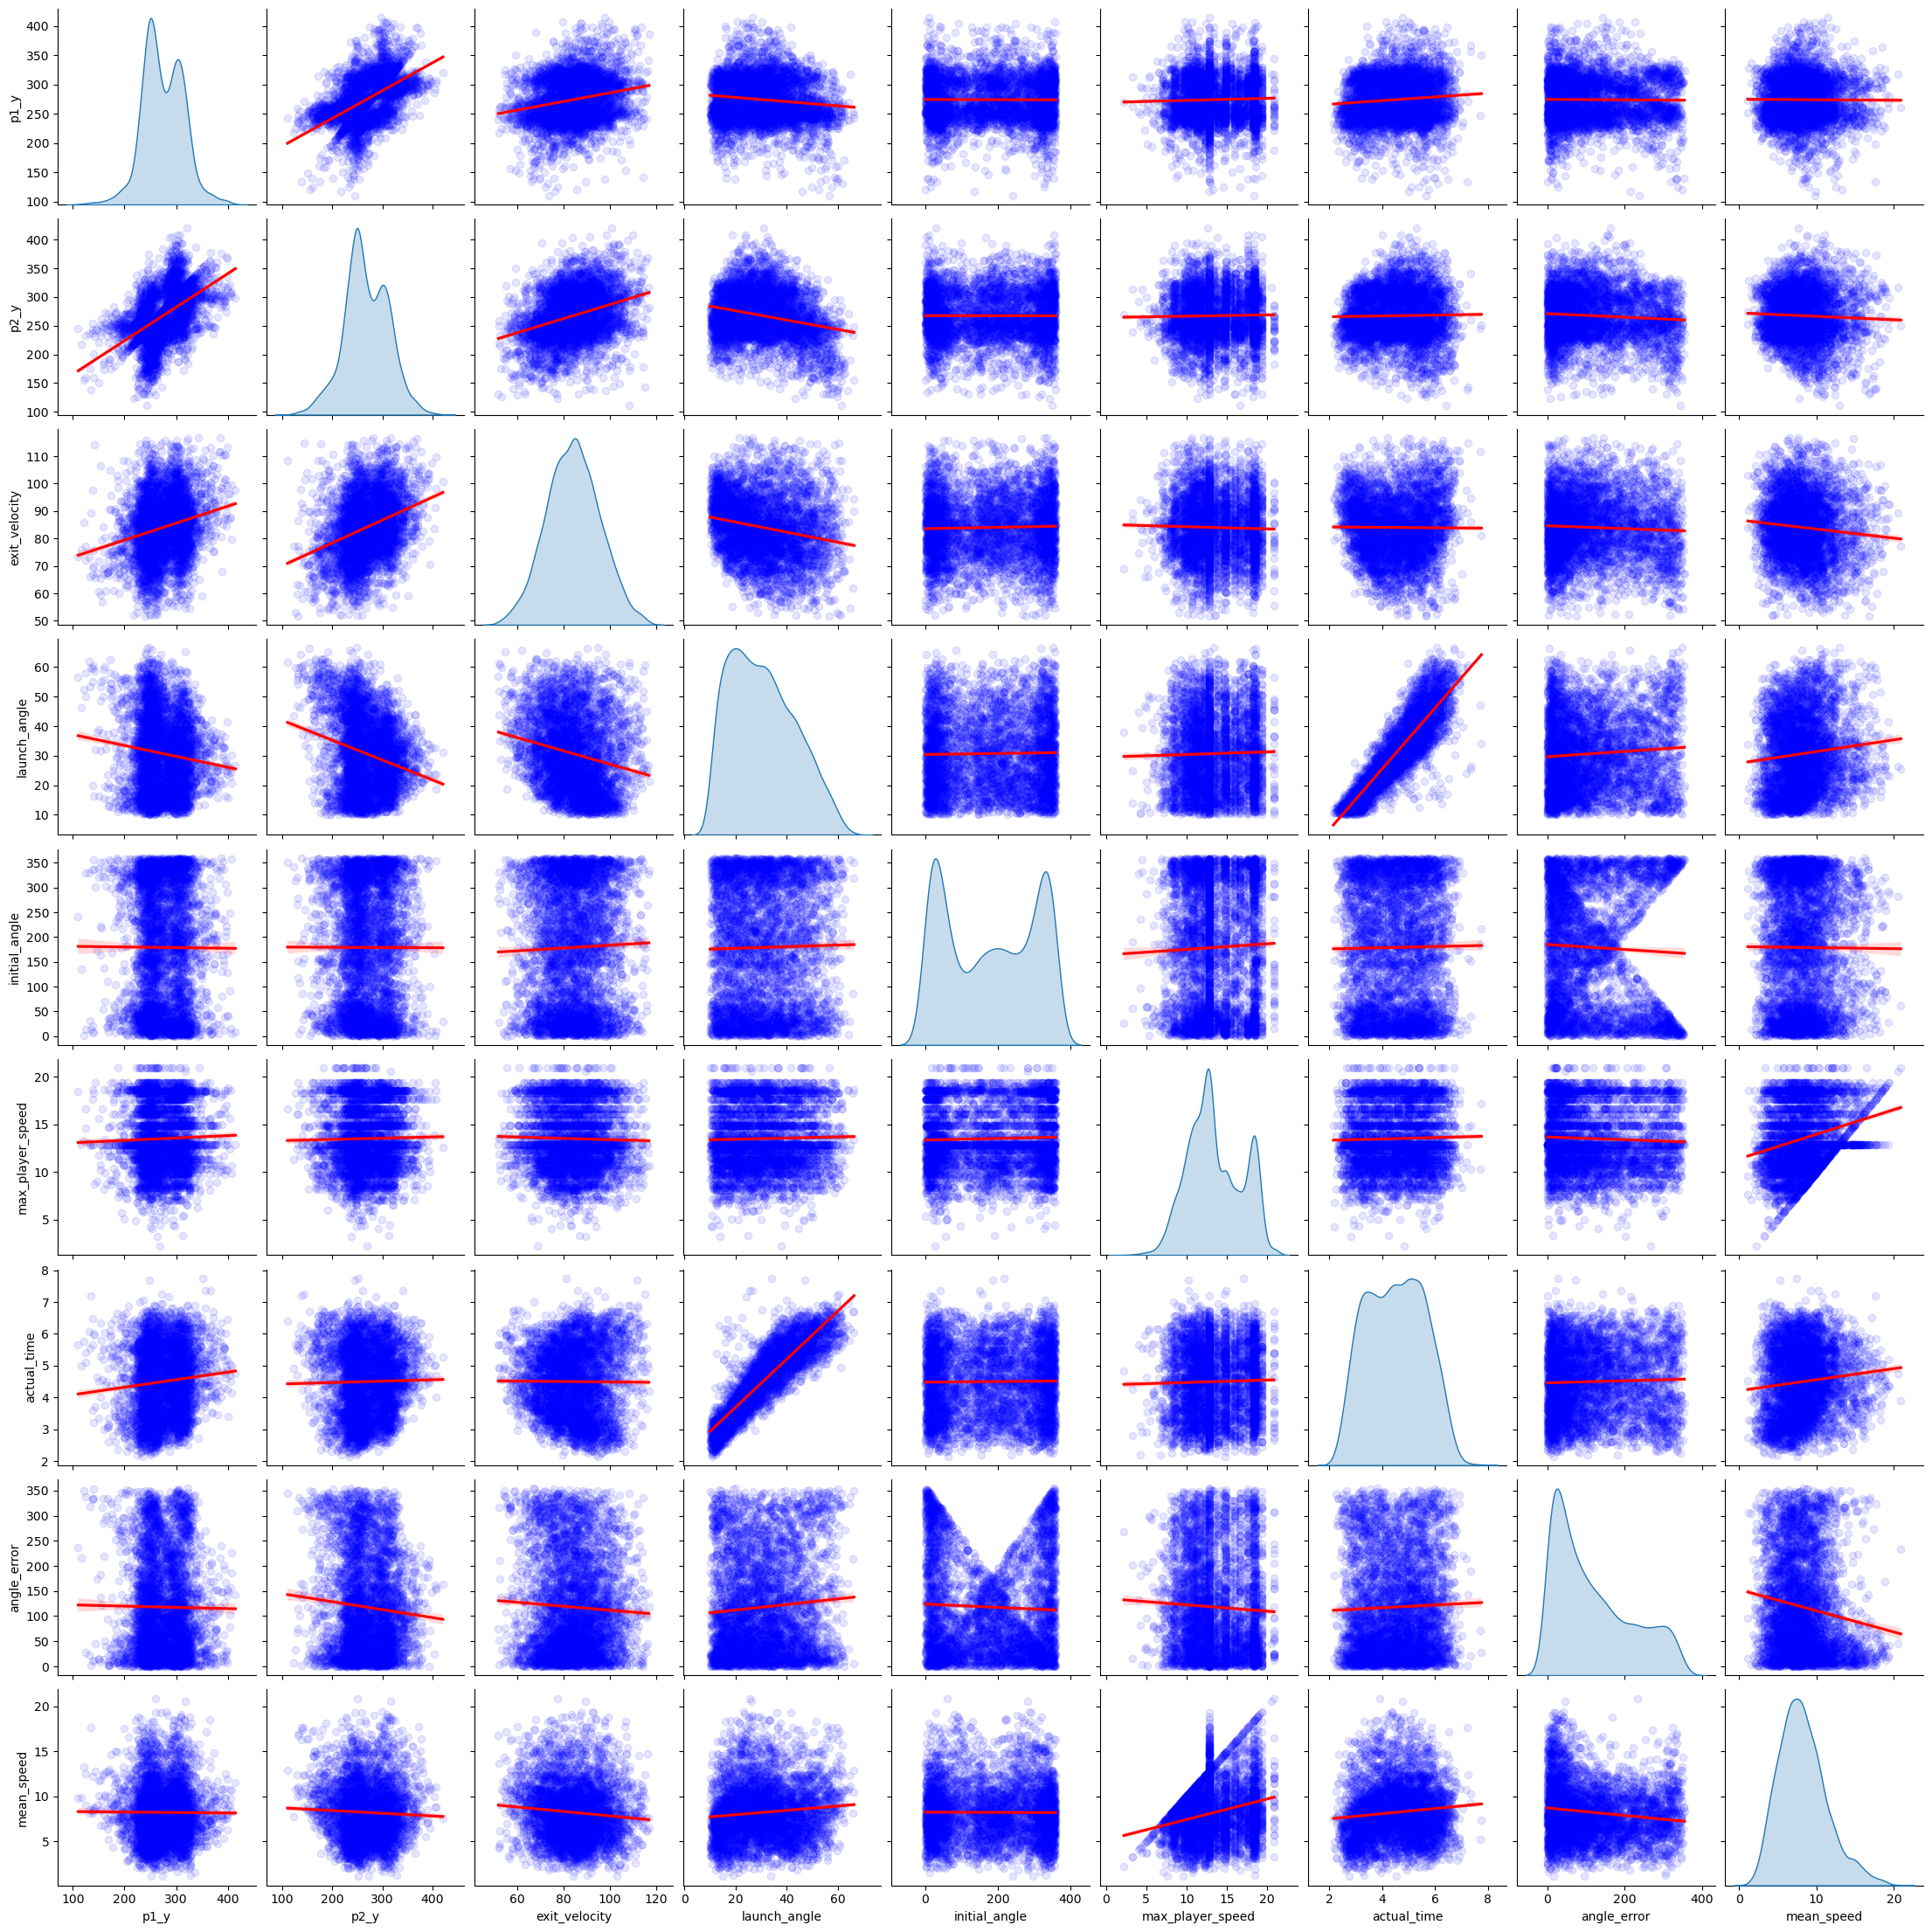

In [28]:
sns.pairplot(final[cols_to_test], kind = 'reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 'color': 'blue'}})



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1200x1000 with 0 Axes>

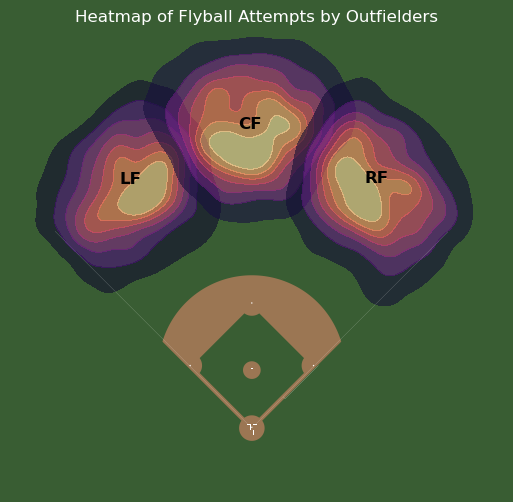

In [10]:
# New heatmap
def plot_heatmap(df):
    field = MiLBField()

    plt.figure(figsize=(12, 10))

    field.draw()

    positions = ['LF', 'CF', 'RF']

    for position in positions:
        position_data = df[df['player_position'] == position]
        sns.kdeplot(
            x=position_data['ball_position_x'],
            y=position_data['ball_position_y'],
            cmap='magma',
            alpha=0.6,
            fill = True,
            levels = 8,
            ax=plt.gca()
        )

        plt.text(position_data.field_x.mean(), position_data.field_y.mean(), 
                 position, fontsize=12, ha='center', color='black', fontweight = 'bold')

    plt.title('Heatmap of Flyball Attempts by Outfielders', c = 'w')

    plt.show()

plot_heatmap(final)

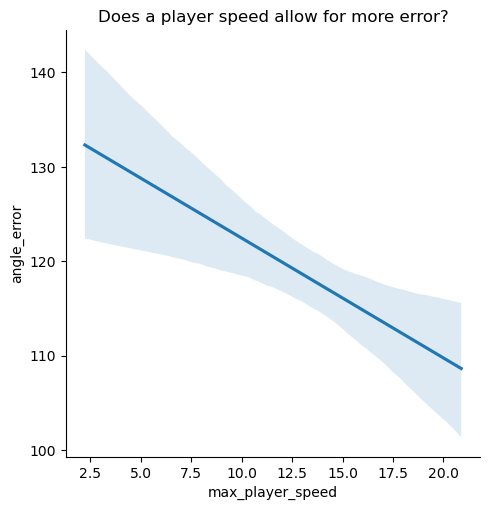

In [29]:
sns.lmplot(x='max_player_speed', y='angle_error', data = final, scatter = False)
plt.title('Does a player speed allow for more error?')
# Interesting, slower players tend to have more error.
plt.show()

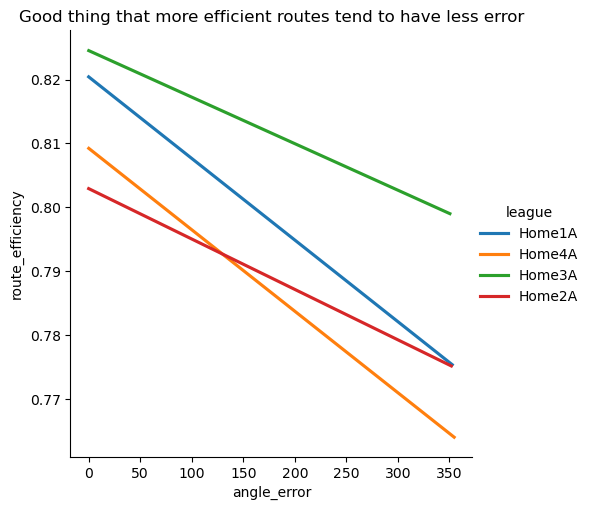

In [33]:
sns.lmplot(x='angle_error', y='route_efficiency', hue = 'league', data = final, scatter = False, ci = 0)
plt.title('Good thing that more efficient routes tend to have less error')
plt.show()

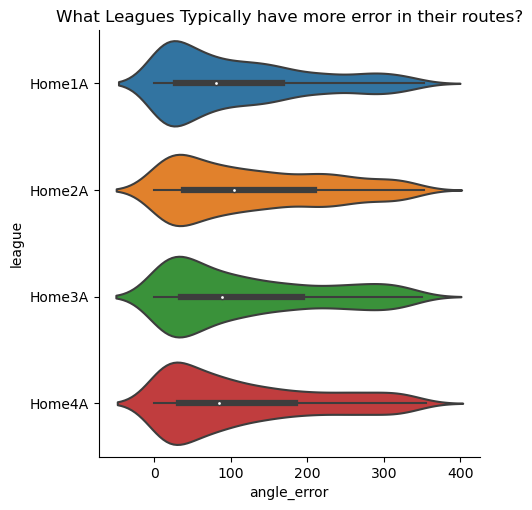

In [69]:
order = ['Home1A', 'Home2A', 'Home3A', 'Home4A']
sns.catplot(x='angle_error', y = 'league', data = final, kind = 'violin', order = order)
plt.title('What Leagues Typically have more error in their routes?')
plt.show()

In [52]:
# Don't think I will eliminate players who aren't in many plays. Will just mention that.
# Check though t0 see as a sanity check of whether there are outfielders with 0000 digits.
final.player_id.value_counts()

player_id
651.0     135
495.0     134
475.0     129
963.0     128
492.0     120
         ... 
6131.0      1
4622.0      1
6378.0      1
2708.0      1
8801.0      1
Name: count, Length: 418, dtype: int64

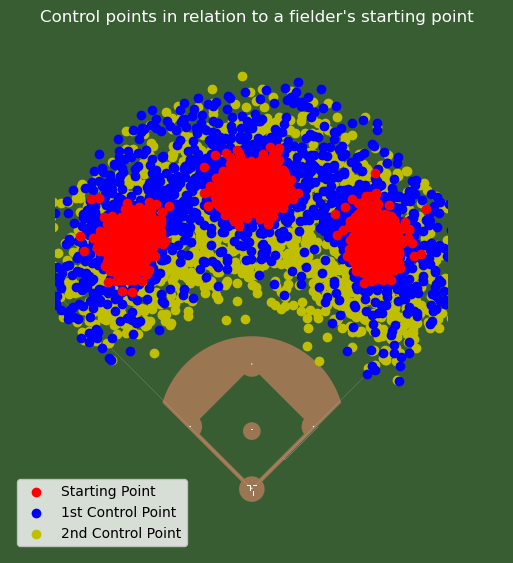

In [29]:
field = MiLBField()
field.draw()
p2 = field.scatter(final['p2_x'], final['p2_y'], c='y', label = '2nd Control Point')
p1 = field.scatter(final['p1_x'], final['p1_y'], c='b', label = '1st Control Point')
s = field.scatter(final['field_x'], final['field_y'], c = 'r', label = 'Starting Point')
plt.title('Control points in relation to a fielder\'s starting point', c='w', pad = 50)

plt.legend(handles = [s, p1, p2])
plt.show()

In [70]:
final.columns

Index(['game_str', 'play_id', 'at_bat', 'play_per_game', 'end_time',
       'player_position', 'event_code', 'almost_caught', 'start_time',
       'player_position_hit', 'inning', 'game_state', 'player_id', 'field_x',
       'field_y', 'handedness', 'ball_position_x', 'ball_position_y',
       'ball_position_z', 'exit_velocity', 'launch_angle', 'field_end_x',
       'field_end_y', 'actual_distance', 'max_speed', 'mean_speed', 'p1_x',
       'p1_y', 'p2_x', 'p2_y', 'initial_angle', 'angle_error', 'straight_line',
       'route_efficiency', 'max_player_speed', 'actual_time', 'league',
       'handedness_encode'],
      dtype='object')

In [ ]:
# Typically what I'm seeing here is that actual time and launch angle are related so I should only pick
# one of the two for the model.


In [118]:
from sklearn.linear_model import LinearRegression 

def annotate(x, y, data, **kwargs): 
    reg = LinearRegression().fit(data[[x]], data[y])
    r2 = reg.score(data[[x]], data[y])
    ax = plt.gca()
    ax.text(.9, .2, 'R^2={:.2f}'.format(r2),
            transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor = 'none'))

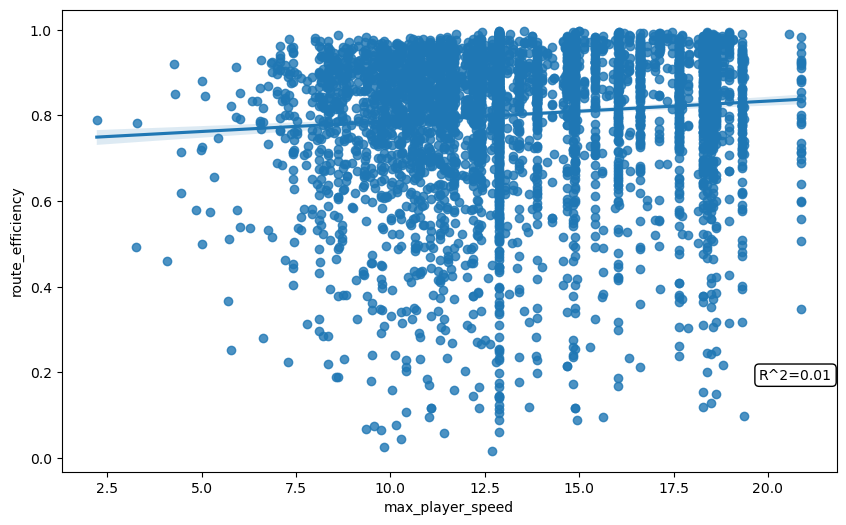

In [119]:
g = sns.regplot(x='max_player_speed', y='route_efficiency', data = final)

annotate('max_player_speed', 'route_efficiency', final, ax = plt.gca())



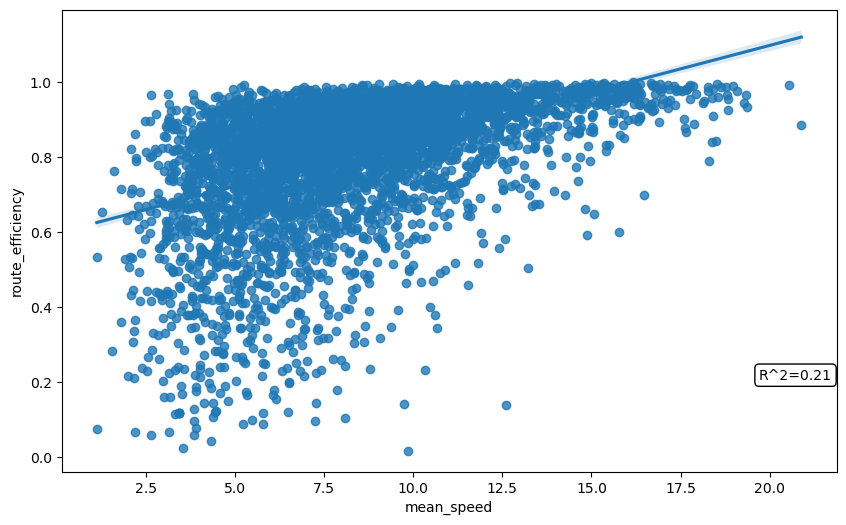

In [120]:
sns.regplot(x='mean_speed', y='route_efficiency', data = final)
annotate('mean_speed', 'route_efficiency', final, ax = plt.gca())


In [30]:
final.to_csv('./Clean/modified_flyball.csv', index = False)